In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [47]:
makati_data_load = pd.read_csv("Data/makati_data.csv")

In [48]:
makati_data_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 23 columns):
hub_code            796 non-null object
schedule            796 non-null object
job_category        796 non-null object
riders              796 non-null int64
rider_yesterday     796 non-null int64
rider_lastweek      796 non-null int64
rider_2week         796 non-null int64
rider_3week         796 non-null int64
rider_4week         796 non-null int64
rider_lastyear      734 non-null float64
rider_52week        736 non-null float64
volume_last7day     796 non-null float64
volume_last3day     796 non-null float64
volume_last14day    796 non-null float64
volume_last21day    796 non-null float64
volume_last28day    796 non-null float64
quarter             796 non-null object
day_of_week         796 non-null object
is_weekend          796 non-null object
month               796 non-null int64
day                 796 non-null int64
is_holiday          796 non-null object
is_after_sale   

In [59]:
# clean the data
makati_data_load['schedule'] = pd.to_datetime(makati_data_load['schedule'])

remove_vars = ['hub_code', 'parcels', 'rider_lastyear', 'rider_52week']
# we remove rider_lastyear and rider_52week since lots of NA and idk how to fill them
name_vars = ['job_category']
dummy_vars = ['quarter', 'day_of_week', 'is_weekend','is_holiday', 'is_after_sale']
value_vars = [x for x in list(makati_data_load.columns) if x not in remove_vars+name_vars+dummy_vars]

makati_data = makati_data_load[name_vars+value_vars]
makati_data = makati_data.sort_values(['job_category', 'schedule']
                                     , ascending = [True, False])

def _dummify(var):
    return pd.get_dummies(makati_data_load[var]
                         , prefix="is")

dummy_df = [_dummify(x) for x in dummy_vars]

makati_data = pd.concat([makati_data]+dummy_df
                       , axis = 1)

# subset the data to only include the last 365 days
makati_data = makati_data.loc[makati_data['schedule']>='2019-01-01']

del makati_data['volume_last3day']

In [60]:
# Let's partition makati_data

md_del = makati_data.loc[makati_data['job_category']=='Delivery']
print(md_del.corr()['riders'].sort_values())

md_pup = makati_data.loc[makati_data['job_category']=='Pickup']
print(md_pup.corr()['riders'].sort_values())

is_weekend           -0.602387
is_sunday            -0.492984
is_holiday           -0.429266
is_saturday          -0.285382
is_not_after_sale    -0.176374
is_Q1                -0.113363
day                  -0.003933
is_Q2                 0.006657
is_Q4                 0.022402
is_3day_after_sale    0.052390
is_2day_after_sale    0.062577
is_1day_after_sale    0.072764
is_5day_after_sale    0.074801
volume_last21day      0.086020
volume_last28day      0.086443
month                 0.093710
is_Q3                 0.094308
is_wednesday          0.109524
is_4day_after_sale    0.123699
volume_last14day      0.124222
is_friday             0.146780
is_monday             0.155552
is_tuesday            0.163511
is_thursday           0.199502
volume_last7day       0.203189
rider_2week           0.356747
rider_3week           0.404828
rider_yesterday       0.410412
rider_4week           0.425750
is_not_holiday        0.429266
rider_lastweek        0.479869
is_weekday            0.602387
riders  

In [61]:
def find_best_model(_df):
    df = _df.sort_values('schedule', ascending=False).reset_index(drop=True)
    row_count = df.shape[0]
    test_partition = round(row_count*0.2)
    
    test_idx = range(test_partition+1)
    train_idx = range(test_partition+1, row_count)

    X_vars = list(df.columns)[3:]
    y_vars = ['riders']

    X_train, X_test = df.loc[train_idx, X_vars], df.loc[test_idx, X_vars]
    y_train, y_test = df.loc[train_idx, y_vars], df.loc[test_idx, y_vars]
    
    params = {'n_estimators': [100, 500]
              , 'learning_rate': [0.01, 0.05, 0.1]}
    clf = GridSearchCV(ensemble.GradientBoostingRegressor(min_samples_split=2
                                                         , loss='ls')
                       , params
                       , cv = 5)
    
    _model = clf
    
    _model.fit(X_train, y_train.values.ravel())
    mse1 = mean_squared_error(y_train, _model.predict(X_train))
    print("MSE: %.1f" % mse1)
    mse = mean_squared_error(y_test, _model.predict(X_test))
    print("MSE: %.1f" % mse)
    
    
    
    pd.DataFrame({"actual":y_train['riders'][::-1]
             , "pred":list(_model.predict(X_train)[::-1])
             }).plot()
    
    pd.DataFrame({"actual":y_test['riders'][::-1]
             , "pred":list(_model.predict(X_test)[::-1])
             }).plot()
    
    
    
    print(pd.DataFrame({"a":X_vars
             , "b": clf.best_estimator_.feature_importances_}).sort_values("b", ascending=False))

    return _model
    

MSE: 65.0
MSE: 262.8
                     a         b
18           is_sunday  0.304912
24          is_holiday  0.141242
25      is_not_holiday  0.131014
8     volume_last28day  0.086983
5      volume_last7day  0.066332
10                 day  0.055318
0      rider_yesterday  0.054022
6     volume_last14day  0.045072
4          rider_4week  0.028926
7     volume_last21day  0.027062
3          rider_3week  0.010976
2          rider_2week  0.010559
9                month  0.010405
14               is_Q4  0.006848
31   is_not_after_sale  0.006765
15           is_friday  0.006186
28  is_3day_after_sale  0.004503
21        is_wednesday  0.001533
12               is_Q2  0.001341
30  is_5day_after_sale  0.000000
29  is_4day_after_sale  0.000000
27  is_2day_after_sale  0.000000
26  is_1day_after_sale  0.000000
11               is_Q1  0.000000
23          is_weekend  0.000000
1       rider_lastweek  0.000000
22          is_weekday  0.000000
20          is_tuesday  0.000000
19         is_thursday

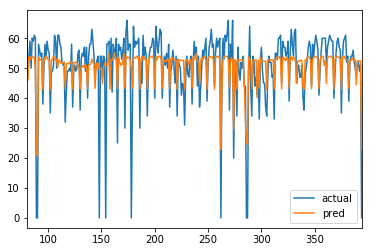

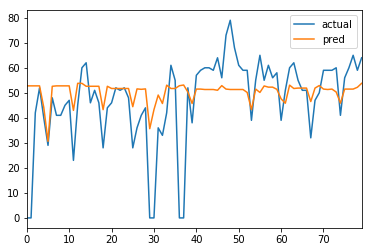

In [62]:
mp = find_best_model(md_pup)

MSE: 45.3
MSE: 141.4
                     a         b
23          is_weekend  0.345865
22          is_weekday  0.254143
24          is_holiday  0.127934
25      is_not_holiday  0.107695
0      rider_yesterday  0.082412
5      volume_last7day  0.023228
2          rider_2week  0.014480
8     volume_last28day  0.012379
7     volume_last21day  0.009304
6     volume_last14day  0.006849
15           is_friday  0.005196
13               is_Q3  0.005006
4          rider_4week  0.002599
10                 day  0.001146
1       rider_lastweek  0.000795
9                month  0.000529
3          rider_3week  0.000439
29  is_4day_after_sale  0.000000
28  is_3day_after_sale  0.000000
27  is_2day_after_sale  0.000000
26  is_1day_after_sale  0.000000
30  is_5day_after_sale  0.000000
16           is_monday  0.000000
21        is_wednesday  0.000000
20          is_tuesday  0.000000
19         is_thursday  0.000000
18           is_sunday  0.000000
17         is_saturday  0.000000
14               is_Q4

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 500], 'learning_rate': [0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

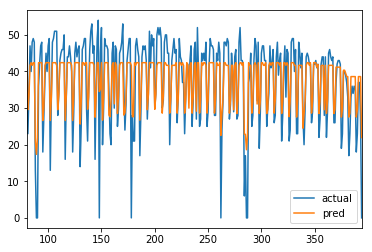

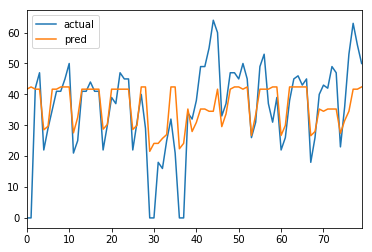

In [63]:
find_best_model(md_del)

NameError: name 'X_train' is not defined

In [49]:
md_pup = md_pup.sort_values('schedule', ascending=False).reset_index(drop=True)

row_count = md_pup.shape[0]

test_partition = round(row_count*0.2)

In [58]:
mp.best_estimator_.predict(X_train)

array([53.28920449, 53.28920449, 53.96654698, 53.91062234, 54.1228314 ,
       52.83104734, 46.77901979, 54.1228314 , 52.45472094, 54.1228314 ,
       54.4991578 , 54.12307945, 54.12307945, 53.50354445, 27.83204522,
       26.26736073, 53.45246625, 52.83104734, 52.83104734, 52.45472094,
       42.64863252, 53.45246625, 52.83104734, 54.4991578 , 53.45246625,
       52.83104734, 52.83104734, 41.20163602, 52.83104734, 52.83104734,
       54.4991578 , 54.1228314 , 52.83104734, 53.12508715, 49.05093101,
       52.454722  , 52.0783956 , 51.45697669, 51.45697669, 51.45697669,
       51.83330309, 42.10412898, 51.45722474, 51.45722474, 51.45722474,
       51.45722474, 52.07864365, 51.83330309, 42.04277708, 51.83330309,
       51.83330309, 51.83330309, 51.45697669, 51.86618654, 51.24476763,
       43.05196983, 51.24476763, 51.62109403, 51.53052976, 51.62109403,
       52.24251294, 51.24476763, 44.59387402, 51.8988529 , 52.2751793 ,
       52.91287809, 53.50141355, 51.83330309, 51.45697669, 44.62

In [11]:
test_idx = range(test_partition+1)
train_idx = range(test_partition+1, row_count)

In [56]:
X_vars = list(md_pup.columns)[3:]
y_vars = ['riders']

X_train, X_test = md_pup.loc[train_idx, X_vars], md_pup.loc[test_idx, X_vars]
y_train, y_test = md_pup.loc[train_idx, y_vars], md_pup.loc[test_idx, y_vars]

In [13]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

In [ ]:
def 

In [14]:
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

C:\Users\daleg\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 269.9679


In [15]:
clf.feature_importances_

array([4.65624986e-02, 3.47865792e-02, 2.27926636e-02, 1.94649531e-02,
       9.57219523e-02, 1.24349451e-01, 2.66548342e-02, 4.15073954e-02,
       7.63783222e-02, 2.18591722e-02, 7.40594656e-02, 3.91264150e-03,
       8.76853800e-03, 1.36621207e-03, 7.92872089e-04, 1.70541777e-02,
       3.15505017e-03, 3.06856552e-05, 1.63305437e-01, 6.21892712e-03,
       1.42961591e-02, 5.38880251e-03, 1.02585999e-03, 1.51624112e-03,
       1.03653835e-01, 8.53772741e-02])

In [16]:
pd.DataFrame({"a":X_vars
             , "b": clf.feature_importances_}).sort_values("b", ascending=False)

,a,b
18,is_sunday,0.163305
5,volume_last7day,0.124349
24,is_holiday,0.103654
4,rider_4week,0.095722
25,is_not_holiday,0.085377
8,volume_last28day,0.076378
10,day,0.074059
0,rider_yesterday,0.046562
7,volume_last21day,0.041507
1,rider_lastweek,0.034787


In [17]:
clf_pup = xgboost_eda(md_pup)

C:\Users\daleg\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 269.7845
                   a         b
18         is_sunday  0.163346
5    volume_last7day  0.124757
4        rider_4week  0.095504
24        is_holiday  0.095298
25    is_not_holiday  0.093663
10               day  0.073743
8   volume_last28day  0.070297
7   volume_last21day  0.048441
0    rider_yesterday  0.046491
1     rider_lastweek  0.033226
6   volume_last14day  0.025216
2        rider_2week  0.022884
9              month  0.022821
3        rider_3week  0.019709
15         is_friday  0.017141
20        is_tuesday  0.014318
12             is_Q2  0.008779
19       is_thursday  0.006220
21      is_wednesday  0.005884
11             is_Q1  0.003601
16         is_monday  0.003165
13             is_Q3  0.001587
22        is_weekday  0.001328
14             is_Q4  0.001314
23        is_weekend  0.001164
17       is_saturday  0.000105


In [129]:
X_train

,rider_yesterday,rider_lastweek,rider_2week,rider_3week,rider_4week,volume_last7day,volume_last14day,volume_last21day,volume_last28day,is_Q1,...,is_monday,is_saturday,is_sunday,is_thursday,is_tuesday,is_wednesday,is_weekday,is_weekend,is_holiday,is_not_holiday
74,65,59,0,58,49,11339.428571,8763.214286,7623.904762,7150.107143,0,...,0,0,0,0,0,0,1,0,0,1
75,59,50,58,54,51,9477.714286,7725.357143,6909.619048,6660.464286,0,...,0,0,0,1,0,0,1,0,0,1
76,64,60,56,59,61,8481.428571,7151.785714,6522.380952,6431.535714,0,...,0,0,0,0,0,1,1,0,0,1
77,61,59,54,56,59,7278.142857,6308.357143,5976.714286,6068.285714,0,...,0,0,0,0,1,0,1,0,0,1
78,48,61,55,55,50,7421.285714,6121.142857,5894.904762,5996.428571,0,...,1,0,0,0,0,0,1,0,0,1
79,54,60,38,35,61,8145.571429,6000.857143,5842.857143,6025.928571,0,...,0,0,1,0,0,0,0,1,0,1
80,59,0,50,49,61,7158.571429,5861.142857,5780.380952,6049.357143,0,...,0,1,0,0,0,0,0,1,0,1
81,50,0,58,49,58,6187.000000,5766.142857,5753.666667,6145.750000,0,...,0,0,0,0,0,0,1,0,0,1
82,60,58,54,51,57,5973.000000,5625.571429,5721.380952,6083.642857,0,...,0,0,0,1,0,0,1,0,0,1
83,59,56,59,61,52,5822.142857,5542.857143,5748.238095,6006.892857,0,...,0,0,0,0,0,1,1,0,0,1


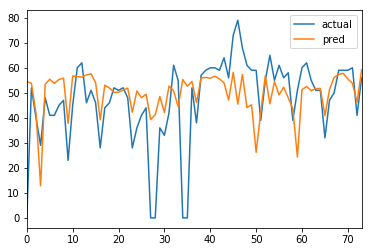

In [18]:

pd.DataFrame({"actual":y_test['riders'][::-1]
             , "pred":list(clf_pup.predict(X_test)[::-1])
             }).plot()



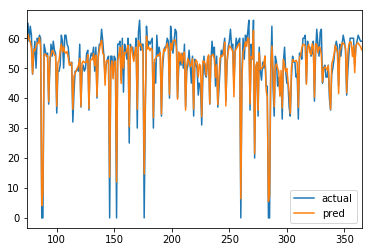

In [19]:
pd.DataFrame({"actual":y_train['riders'][::-1]
             , "pred":list(clf_pup.predict(X_train)[::-1])
             }).plot()

In [131]:
y_test['riders']

0      0
1     52
2     40
3     29
4     48
5     41
6     41
7     45
8     47
9     23
10    45
11    60
12    62
13    46
14    51
15    46
16    28
17    44
18    46
19    52
20    51
21    52
22    48
23    28
24    36
25    41
26    44
27     0
28     0
29    36
      ..
44    56
45    73
46    79
47    68
48    61
49    59
50    59
51    39
52    55
53    65
54    55
55    61
56    56
57    58
58    39
59    51
60    60
61    62
62    55
63    51
64    51
65    32
66    47
67    50
68    59
69    59
70    59
71    60
72    41
73    56
Name: riders, Length: 74, dtype: int64